In [1]:
!pip freeze | grep torch

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
torch==0.4.1
torchvision==0.2.1


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from sklearn.metrics import log_loss
from skopt import gp_minimize

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_j import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
os.getcwd()

'/home/dsgpucp/Documents/DSG-2018-Finals'

In [3]:
from src.utils_f import duration_feature, watched_category
import lightgbm as lgbm

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')
productid_category = pd.read_csv('data/raw/productid_category.csv')

In [6]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.2)

In [7]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [8]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
proc_train.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION
0,xn8rwYNMzowpxbL53w7dqVwY2zBFF+2uFVt5s7ulcv02Ea...,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.312500,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.375,16.0,0.0,0.250000,0.0,0.312500,0.062500,0.0,0.000000,0.375,16.0,3582.587489
1,a65+67pVNWnc52JNRETXtJ4rhgN9d4dnfcRStuO/8yh1mG...,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.000,5.0,0.0,0.600000,0.0,0.200000,0.000000,0.0,0.200000,0.000,5.0,292.866757
2,afL2CkgjhWp5bA6iZpc8PtyY7/39eAclH5uQiGuT/Q26bp...,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.071429,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.000,14.0,0.0,0.214286,0.0,0.071429,0.142857,0.0,0.571429,0.000,14.0,696.393210
3,VU3EoS7rUHQTuSRBsGf61QFXVy4LdWKnKecr9UAnA0ajZT...,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.200000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.000,5.0,0.0,0.200000,0.0,0.200000,0.200000,0.0,0.400000,0.000,5.0,172.945998
4,Ougsx+wlnuM+5sGKDHbWu+3/cBoj6KdN0yaq65y+XjwH60...,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.000000,0.428571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,7.0,0.0,0.571429,0.0,0.000000,0.428571,0.0,0.000000,0.000,7.0,120.140638


# Validation

In [10]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [11]:
X_train.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION
0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.312500,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.375,16.0,0.0,0.250000,0.0,0.312500,0.062500,0.0,0.000000,0.375,16.0,3582.587489
1,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.000,5.0,0.0,0.600000,0.0,0.200000,0.000000,0.0,0.200000,0.000,5.0,292.866757
2,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.071429,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.000,14.0,0.0,0.214286,0.0,0.071429,0.142857,0.0,0.571429,0.000,14.0,696.393210
3,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.200000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.000,5.0,0.0,0.200000,0.0,0.200000,0.200000,0.0,0.400000,0.000,5.0,172.945998
4,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.000000,0.428571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,7.0,0.0,0.571429,0.0,0.000000,0.428571,0.0,0.000000,0.000,7.0,120.140638


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)


In [13]:
X_train.shape

(106498, 32)

In [14]:
temp_columns.shape

(32,)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train)

X_train_pca = (pca.transform(X_train))
X_val_pca = (pca.transform(X_val))

X_train = pd.concat([pd.DataFrame(X_train, columns=temp_columns), pd.DataFrame(X_train_pca)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val, columns=temp_columns), pd.DataFrame(X_val_pca)], axis=1)

In [16]:
X_train.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,0,1,2,3,4,5,6,7,8,9
0,-0.138602,-0.093915,-0.324053,-0.044024,-0.052692,-0.019365,-0.357413,1.296757,0.325872,-0.227469,-0.696312,-0.17078,-0.180751,-0.031786,-0.018079,-0.06685,-0.012462,-0.012,-0.078353,-1.056623,1.893193,0.403978,-0.374988,-0.019365,-0.357413,1.296757,-0.589821,-0.100321,-1.056623,1.893193,0.403978,0.213369,-1.757239,-1.873060,-1.313781,-0.257228,1.692050,0.224113,1.126898,-0.135493,-0.615188,0.053173
1,-0.138602,-0.093915,-0.324053,-0.044024,-0.052692,1.293017,-0.357413,0.573412,-0.393682,-0.227469,-0.696312,-0.17078,-0.180751,-0.031786,-0.018079,-0.06685,-0.012462,-0.012,-0.078353,-0.405625,-0.430615,-0.360947,-0.374988,1.293017,-0.357413,0.573412,-1.025047,-0.100321,-0.405625,-0.430615,-0.360947,-0.334176,-1.091834,0.488798,-1.495057,-0.141014,-0.574451,0.583127,-0.047408,-1.432350,0.059557,-0.356106
2,-0.138602,-0.093915,-0.324053,-0.044024,-0.052692,-0.153282,-0.357413,-0.253268,-0.393682,-0.227469,0.453762,-0.17078,-0.180751,-0.031786,-0.018079,-0.06685,-0.012462,-0.012,-0.078353,0.803371,-0.430615,0.264901,-0.374988,-0.153282,-0.357413,-0.253268,-0.030243,-0.100321,0.803371,-0.430615,0.264901,-0.267013,1.447909,0.486904,0.104669,-0.265125,-0.191271,-0.297767,0.354261,-0.398111,0.120867,-0.038010
3,-0.138602,-0.093915,-0.324053,-0.044024,-0.052692,-0.206848,-0.357413,0.573412,-0.393682,-0.227469,0.913791,-0.17078,-0.180751,-0.031786,-0.018079,-0.06685,-0.012462,-0.012,-0.078353,0.245373,-0.430615,-0.360947,-0.374988,-0.206848,-0.357413,0.573412,0.367679,-0.100321,0.245373,-0.430615,-0.360947,-0.354136,0.953801,0.031342,-0.829063,-0.444112,-0.759033,0.009651,0.220883,0.566929,-0.318314,-0.199470
4,-0.138602,-0.093915,-0.324053,-0.044024,-0.052692,1.185884,-0.357413,-0.712534,4.540400,-0.227469,-0.696312,-0.17078,-0.180751,-0.031786,-0.018079,-0.06685,-0.012462,-0.012,-0.078353,-1.056623,-0.430615,-0.221870,-0.374988,1.185884,-0.357413,-0.712534,1.959365,-0.100321,-1.056623,-0.430615,-0.221870,-0.362925,-2.729011,3.016117,-0.083550,-1.217812,-0.905506,-1.182338,0.339411,0.676824,-0.400849,0.858247


In [17]:
X_train.to_csv('data/processed/X_train_pca.csv')
X_val.to_csv('data/processed/X_val_pca.csv')

In [47]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284373
[200]	valid_0's binary_logloss: 0.278238
[300]	valid_0's binary_logloss: 0.275797
[400]	valid_0's binary_logloss: 0.274696
[500]	valid_0's binary_logloss: 0.27417
[600]	valid_0's binary_logloss: 0.273902
[700]	valid_0's binary_logloss: 0.273811
[800]	valid_0's binary_logloss: 0.273776
Early stopping, best iteration is:
[798]	valid_0's binary_logloss: 0.273773


In [48]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=774, verbose_eval=100)

[100]	valid_0's binary_logloss: 0.284373
[200]	valid_0's binary_logloss: 0.278238
[300]	valid_0's binary_logloss: 0.275797
[400]	valid_0's binary_logloss: 0.274696
[500]	valid_0's binary_logloss: 0.27417
[600]	valid_0's binary_logloss: 0.273902
[700]	valid_0's binary_logloss: 0.273811


# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=774, verbose_eval=)

In [18]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [19]:
scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)
X_test = scaler.transform(X_test)

In [20]:
pca = PCA(n_components = 10).fit(X_all)

X_all_pca = pd.DataFrame(pca.transform(X_all))
X_test_pca = pd.DataFrame(pca.transform(X_test))

X_all = pd.concat([pd.DataFrame(X_all, columns=temp_columns), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test, columns=temp_columns), pd.DataFrame(X_test_pca)], axis=1)

In [21]:
X_all.to_csv('data/processed/X_all_pca.csv')
X_test.to_csv('data/processed/X_test_pca.csv')

In [24]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=774)

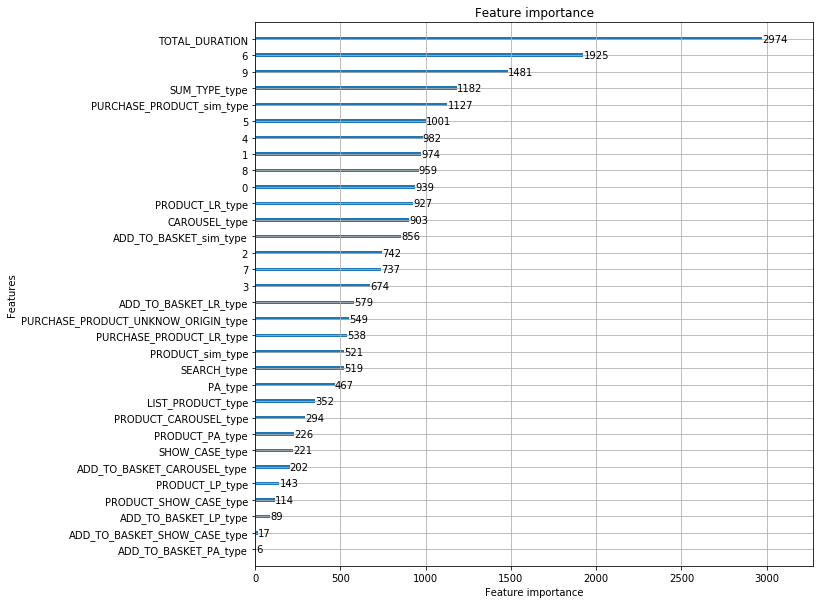

In [25]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [26]:
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_3_submit.csv', index=False)

# Bayesian Tuning 

In [22]:
import warnings
import gc
from sklearn.metrics import log_loss
from skopt import gp_minimize
warnings.filterwarnings("ignore")

In [26]:
space  = [Integer(3, 50, name='max_depth'),
          Integer(5, 50, name='num_leaves'),
          Integer(10, 300, name='min_child_samples'),
          Real(1, 500,  name='scale_pos_weight'),
          Real(0.2, 0.9, name='subsample'),
          Real(0.2, 0.9, name='colsample_bytree'),
          Real(0.001, 1, name='learning_rate'),
          Real(0.001, 5, name='lambda_l2')
         ]

In [27]:
def objective(values):
    

    params = {'max_depth': values[0], 
              'num_leaves': values[1], 
              'min_child_samples': values[2], 
              'scale_pos_weight': values[3],
              'subsample': values[4],
              'colsample_bytree': values[5],
              'metric':'binary_logloss',
              'nthread': 8,
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'learning_rate': values[6],
              'max_bin': 100,
              'lambda_l2': values[7],
              'min_child_weight': 0,
              'min_split_gain': 0,
              'subsample_freq': 1}
    

    print('\nNext set of params.....',params)
    
    
    early_stopping_rounds = 30
    num_boost_round       = 100000
    
    d_train = lgbm.Dataset(X_train, label=trn_session.target)
    d_valid = lgbm.Dataset(X_val, label=val_session.target)
        
    evals_results = {}
    model_lgbm    = lgbm.train(params,d_train,valid_sets=[d_valid], 
                               num_boost_round=num_boost_round,
                               early_stopping_rounds=early_stopping_rounds,
                               verbose_eval=None, feval=None)
    
    
    loss = log_loss(y_val, model_lgbm.predict(X_val))
    
    print('\nlog loss.....',loss,".....iter.....", model_lgbm.current_iteration())
    
    gc.collect()
    
    return  loss

In [28]:
res_gp = gp_minimize(objective, space, n_random_starts=10, n_calls=50, random_state=42, verbose=True)
p
rint('Best score=%.4f' % res_gp.fun)

Iteration No: 1 started. Evaluating function at random point.

Next set of params..... {'max_depth': 40, 'num_leaves': 13, 'min_child_samples': 236, 'scale_pos_weight': 298.82822881529705, 'subsample': 0.5120829269975138, 'colsample_bytree': 0.26998244107260205, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.4597896430739014, 'max_bin': 100, 'lambda_l2': 1.6692093470839702, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

log loss..... 2.210216514798188 .....iter..... 1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4604
Function value obtained: 2.2102
Current minimum: 2.2102
Iteration No: 2 started. Evaluating function at random point.

Next set of params..... {'max_depth': 10, 'num_leaves': 34, 'min_child_samples': 26, 'scale_pos_weight': 361.2773873611456, 'subsample': 0.8569868963110252, 'colsample_bytree': 0.20054513608871005, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_ty

NameError: name 'p' is not defined

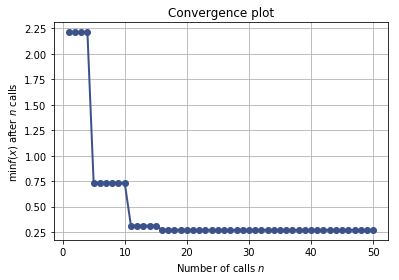

In [29]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [30]:
flds = ['max_depth',
        'num_leaves',
        'min_child_samples',
        'scale_pos_weight',
        'subsample',
        'colsample_bytree',
        'learning_rate',
        'lambda_l2']

In [31]:
best_params = {i:j for i,j in zip(flds, res_gp.x)}
print('best parameters:')
print(best_params)

best parameters:
{'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'scale_pos_weight': 1.0, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.2, 'learning_rate': 0.04591415630383757, 'lambda_l2': 5.0}


In [32]:
params = {
    'objective' :'binary',
    'max_depth' : 9,
    'num_leaves': 50,
    'min_child_samples': 10,
    'scale_pos_weight': 1.0,
    'subsample': 0.866999534037008,
    'colsample_bytree': 0.2,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.0459,
    'lambda_l2': 5.0,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=y_train)
d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000,
                early_stopping_rounds=30,
                verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.273112
[200]	valid_0's binary_logloss: 0.272254
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.272034


In [93]:
params = {
    'objective' :'binary',
    'max_depth' : 8,
    'num_leaves': 21,
    'min_child_samples': 20,
    'scale_pos_weight': 1.0496425512948,
    'subsample': 0.866999534037008,
    'colsample_bytree': 0.5849166790692155,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.03410173379388409,
    'lambda_l2': 0.7395218933709418,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)

clf = lgbm.train(params, d_train, # valid_sets=[d_valid],
                num_boost_round=61,
                verbose_eval=10)

In [94]:
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_8_submit.csv', index=False)

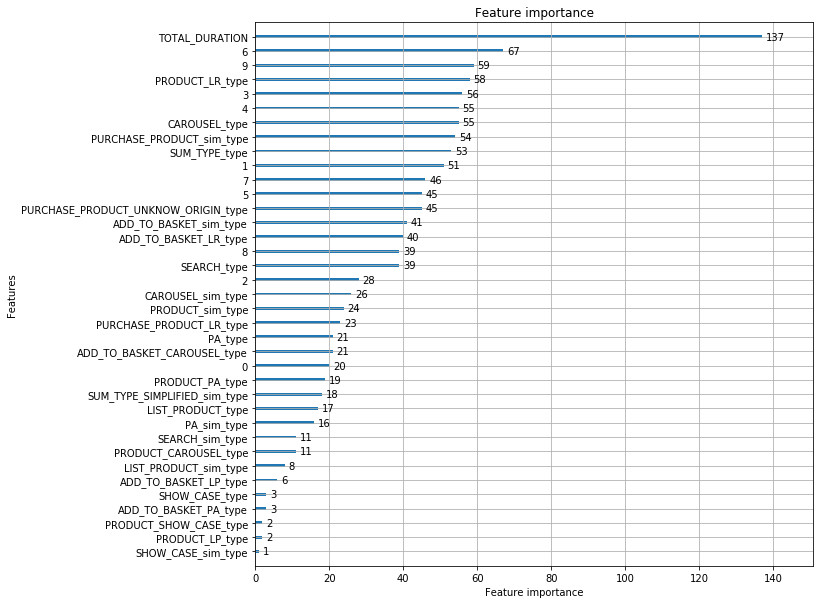

In [95]:
lgbm.plot_importance(clf)